# CMD plots showing the effect of filtering on RUWE

Reproduce the figures on slides 41 to 46 of the [presentation](https://www.cosmos.esa.int/documents/29201/1770596/Lindegren_GaiaDR2_Astrometry_extended.pdf/1ebddb25-f010-6437-cb14-0e360e2d9f09) by L. Lindegren et al.

### The renormalized unit weight error

The unit weight error is given by:

\begin{equation}
    \text{UWE} = \left(\frac{\text{astrometric_chi2_al}}{\text{astrometric_n_good_obs_al}-5)}\right)^{1/2}\,.
\end{equation}

In the second and third query above the value of UWE is already calculated as part of the ADQL query. This value is then renormalized by dividing by the typical value for the UWE, $u_0$, as a function of colour and magnitude.

\begin{equation}
    \text{RUWE} = \frac{\text{UWE}}{u_0(G, G_\mathrm{BP}-G_\mathrm{RP})}\,.
\end{equation}

### Example query

The Gaia DR2 archive query for the input data to the plots below is:
```
select source_id, bp_rp, phot_g_mean_mag, parallax, 
sqrt(astrometric_chi2_al/(astrometric_n_good_obs_al-5)) as u
from gaiadr2.gaia_source
where parallax>10
and parallax_over_error>10
and phot_bp_mean_flux_over_error>10
and phot_rp_mean_flux_over_error>10
```

__NOTE__ The value of the UWE is calculated as part of the query. You can download the `astrometric_chi2_al` and `astrometric_n_good_obs_al` columns and then do the calculation yourself. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

from ruwetools import U0Interpolator

In [2]:
alldata = Table.read('dr2data/LLRuweSelection.fits', format='fits')
print("Number of sources in input table: {0}".format(alldata['bp_rp'].size))

gabs = alldata['phot_g_mean_mag']+5*np.log10(alldata['parallax'])-10

rwi = U0Interpolator()
ruwe = alldata['u']/rwi.get_u0(alldata['phot_g_mean_mag'], alldata['bp_rp'])

Number of sources in input table: 338833


## Raw HRD, no UWE or RUWE filtering

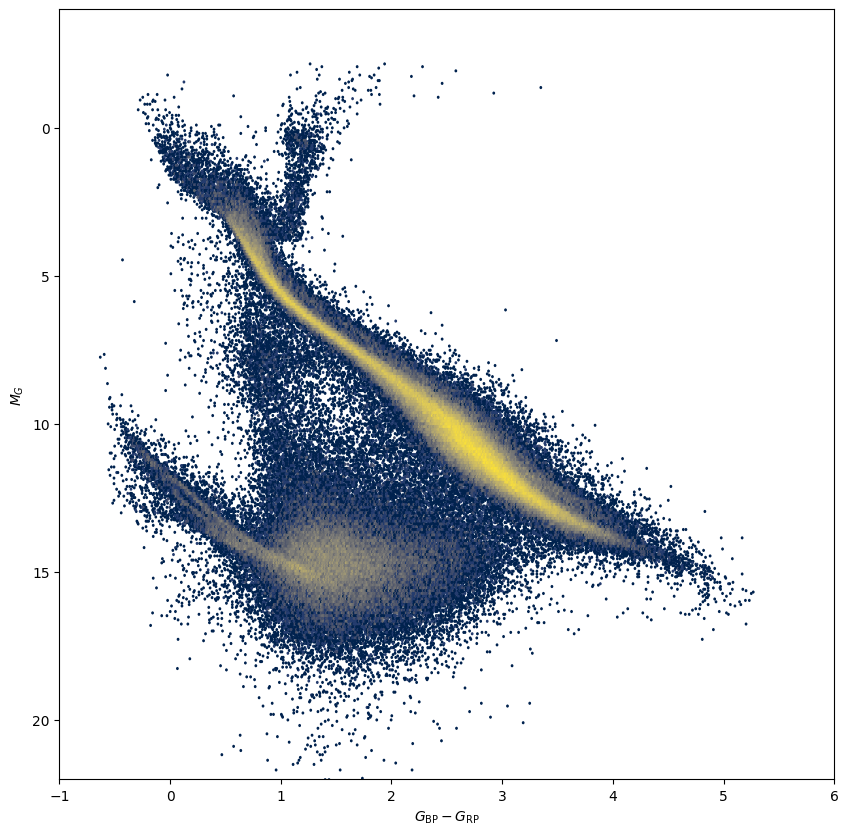

In [3]:
figa, axa = plt.subplots(1, 1, figsize=(10,10))

axa.hexbin(alldata['bp_rp'], gabs, mincnt=1, bins='log', gridsize=500, cmap='cividis')
axa.set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
axa.set_ylabel(r'$M_G$')
axa.set_xlim(-1,6)
axa.set_ylim(-4,22)
axa.invert_yaxis()

plt.show()

## UWE and RUWE histograms

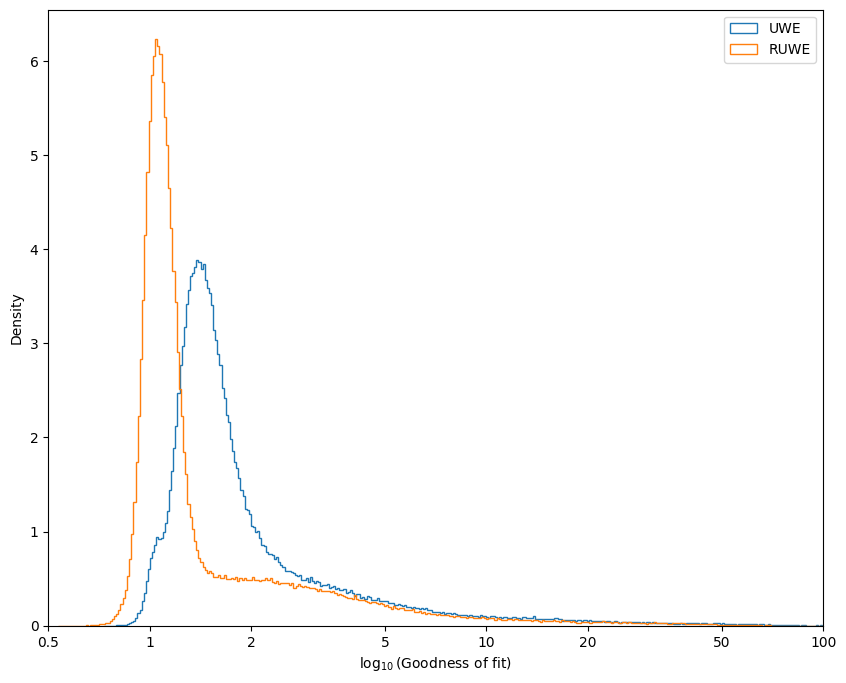

In [4]:
figb, axb = plt.subplots(1, 1, figsize=(10,8))

axb.hist(np.log10(alldata['u']), bins='auto', histtype='step', density=True, label='UWE')
axb.hist(np.log10(ruwe), bins='auto', histtype='step', density=True, label='RUWE')
axb.legend(loc='best')
axb.set_xticks(np.log10([0.5,1,2,5,10,20,50,100]), minor=False)
axb.set_xticklabels(['0.5','1','2','5','10','20','50','100'], minor=False)
axb.set_xlabel('$\log_{10}(\mathrm{Goodness\ of\ fit})$')
axb.set_ylabel('Density')
axb.set_xlim(np.log10(0.5),np.log10(100))

plt.show()

## HR diagrams with UWE/RUWE filtering

Number of source with UWE<1.96: 236339
Number of source with RUWE<1.40: 236632


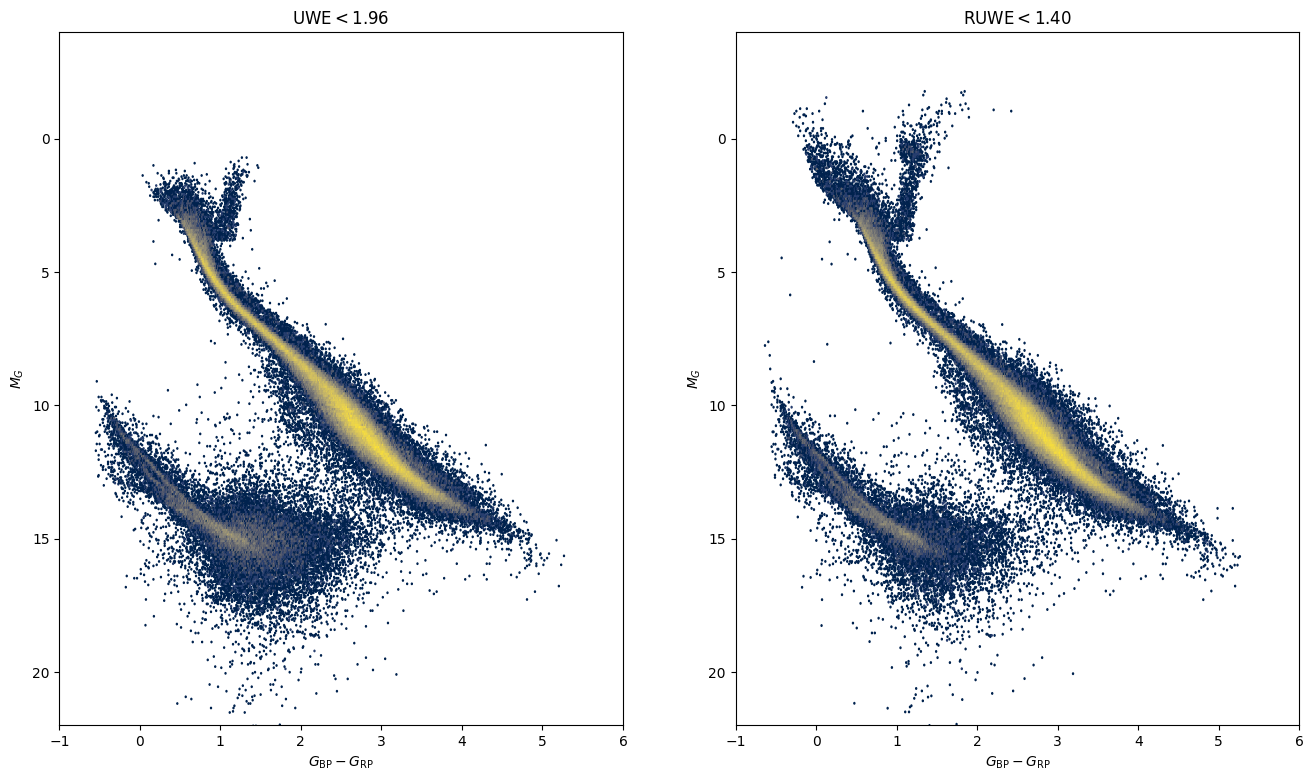

In [5]:
figc, (axc, axd) = plt.subplots(1, 2, figsize=(16,9))

uwefilter = alldata['u']<1.96
ruwefilter = ruwe<1.40

axc.hexbin(alldata['bp_rp'][uwefilter], gabs[uwefilter], mincnt=1, bins='log', gridsize=500, cmap='cividis')
axc.set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
axc.set_ylabel(r'$M_G$')
axc.set_xlim(-1,6)
axc.set_ylim(-4,22)
axc.invert_yaxis()
axc.set_title('UWE$<1.96$')

axd.hexbin(alldata['bp_rp'][ruwefilter], gabs[ruwefilter], mincnt=1, bins='log', gridsize=500, cmap='cividis')
axd.set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
axd.set_ylabel(r'$M_G$')
axd.set_xlim(-1,6)
axd.set_ylim(-4,22)
axd.invert_yaxis()
axd.set_title('RUWE$<1.40$')

print('Number of source with UWE<1.96: {0}'.format(gabs[uwefilter].size))
print('Number of source with RUWE<1.40: {0}'.format(gabs[ruwefilter].size))

plt.show()

Number of source with UWE<1.96, RUWE>=1.4: 14982
Number of source with RUWE<1.40, UWE>=1.96: 15275


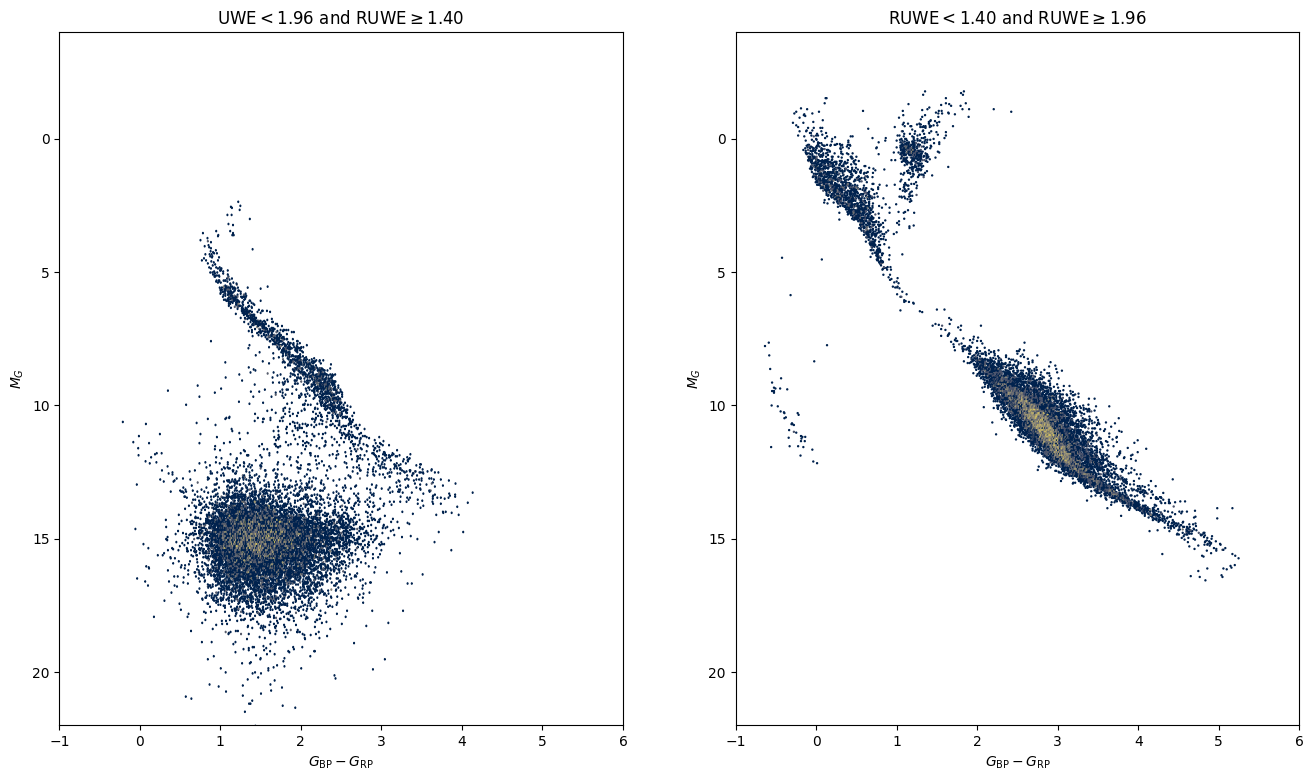

In [6]:
figd, (axe, axf) = plt.subplots(1, 2, figsize=(16,9))

filterA = (alldata['u']<1.96) & (ruwe>=1.4)
filterB = (ruwe<1.40) & (alldata['u']>=1.96)

axe.hexbin(alldata['bp_rp'][filterA], gabs[filterA], mincnt=1, bins='log', gridsize=500, cmap='cividis')
axe.set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
axe.set_ylabel(r'$M_G$')
axe.set_xlim(-1,6)
axe.set_ylim(-4,22)
axe.invert_yaxis()
axe.set_title('UWE$<1.96$ and RUWE$\geq1.40$')

axf.hexbin(alldata['bp_rp'][filterB], gabs[filterB], mincnt=1, bins='log', gridsize=500, cmap='cividis')
axf.set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
axf.set_ylabel(r'$M_G$')
axf.set_xlim(-1,6)
axf.set_ylim(-4,22)
axf.invert_yaxis()
axf.set_title('RUWE$<1.40$ and RUWE$\geq1.96$')

print('Number of source with UWE<1.96, RUWE>=1.4: {0}'.format(gabs[filterA].size))
print('Number of source with RUWE<1.40, UWE>=1.96: {0}'.format(gabs[filterB].size))

plt.show()